In [47]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go # for fancy interactive plot
import seaborn as sns
import requests
import re
from bs4 import BeautifulSoup
import os # to check if directory exists and create it if it doesn't
from datetime import datetime # to parse speech date
from nrclex import NRCLex
import spacy
import en_core_web_md
import csv
import prince # for correspondence analysis
import nltk
from scipy.stats import power_divergence # for g-test (log likelihood ratio)
from scipy.stats.contingency import association
from scipy.stats import chi2_contingency
from scipy.stats import chi2
stopwords = pd.read_table('./word_lists/kaggle_stopwords.txt')

In [3]:
#cont_table = pd.read_csv('ContingencyTable.csv', index_col=0)
cont_table = pd.read_csv('obamaContingencyTable.csv', index_col=0)
cont_table = cont_table.astype(int)

<A HREF="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.power_divergence.html">SciPy power divergence for G-test or log-likelihood ratio</A> set lambda_='log-likelihood' for g-test

In [4]:
g_test = power_divergence(cont_table, lambda_='log-likelihood')

<A HREF="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html#scipy.stats.contingency.association">SciPy association</A>

In [5]:
# Association: A value of 1.0 indicates perfect association, and 0.0 means the variables have no association
association(cont_table, method="cramer")

0.2570188577665141

In [6]:
#cont_table.iloc[0:5, 11875:]

In [7]:
len(g_test[0])

11904

<A HREF="https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html">SciPy contingency table Chi2 test</A>

from <A HREF="https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test">Wikipedia</A> : In cases where the expected value, E, is found to be small (indicating a small underlying population probability, and/or a small number of observations), the normal approximation of the multinomial distribution can fail, and in such cases it is found to be more appropriate to use the G-test, a likelihood ratio-based test statistic

In [8]:
# H0: observed frequencies are independent
res_chi2 = chi2_contingency(cont_table)
print("Statistic:",res_chi2[0],"\tp-value:",res_chi2[1],"\tdf:",res_chi2[2])
# pval<0.001 reject H0, there is a difference in counts of words between the various speeches

Statistic: 1670601.1656305655 	p-value: 0.0 	df: 1178397


In [50]:
chi2.stats(res_chi2[2])

(array(1178397.), array(2356794.))

Starting with <A HREF="https://aclanthology.org/J93-1003/">Dunning 1993</A> the g-test (likelihood ratio) became popular for computational linguistics

In [9]:
res_gtest = chi2_contingency(cont_table, lambda_="log-likelihood") # g-test
print("Statistic:",res_gtest[0],"\tp-value:",res_gtest[1],"\tdf:",res_gtest[2])

Statistic: 424731.9812949751 	p-value: 1.0 	df: 1178397


In [10]:
col_sums = np.reshape(cont_table.sum(axis=0).to_numpy(), (-1,1))
row_sums = np.reshape(cont_table.sum(axis=1).to_numpy(), (-1,1))
total = row_sums.sum()

In [11]:
expected = pd.DataFrame(np.matmul(row_sums, np.transpose(col_sums))/total, columns=cont_table.columns, index=cont_table.index)

In [12]:
difference = cont_table.subtract(expected)

### Date of speech of interest

In [117]:
# Sort words from one speech by difference between observed and expected
date = '2011-09-09'
# Words occuring more often than expected - over represented
difference[difference.index.str.startswith(date)].iloc[0].sort_values(ascending=False)[0:20]

jobs         30.627760
will         22.752825
this         22.589107
for          22.491515
tax          20.628559
it           20.526774
right        17.660025
if           17.320649
pass         16.677155
should       14.482770
bill         13.402907
companies    13.047798
plan         12.983468
have         12.623368
their        12.367448
can          11.351715
an           10.497904
now          10.239788
away          9.483568
we            9.470392
Name: 2011-09-09-SpeechJobsAct, dtype: float64

In [118]:
# Words occuring less often than expected
difference[difference.index.str.startswith(date)].iloc[0].sort_values(ascending=False)[-20:]

when       -4.840674
in         -5.304356
my         -5.308110
today      -5.549694
me         -5.872140
from       -5.922533
so         -5.922932
but        -6.117118
those      -6.211716
with       -6.601685
because    -6.711816
as         -9.747075
i          -9.749471
was       -10.179651
that      -10.936708
is        -11.766202
our       -11.979315
the       -24.828813
of        -30.925168
â         -32.103182
Name: 2011-09-09-SpeechJobsAct, dtype: float64

In [119]:
# LOAD CONTINGENCY TABLE
# Read in saved contingency table
ctab = pd.read_csv('obamaContingencyTable.csv',index_col=0) 
# Shorten row index names to date only
ctab = ctab.rename(index = lambda x: x[0:10])
ca = prince.CA(n_components=2,
               n_iter=3,copy=True,
               check_input=True,
               engine='auto',
               random_state=33)

In [120]:
%matplotlib notebook

### Ok, let's cram this into one cell. Enter data of interest at top... out pops a nice CA plot

<IPython.core.display.Javascript object>


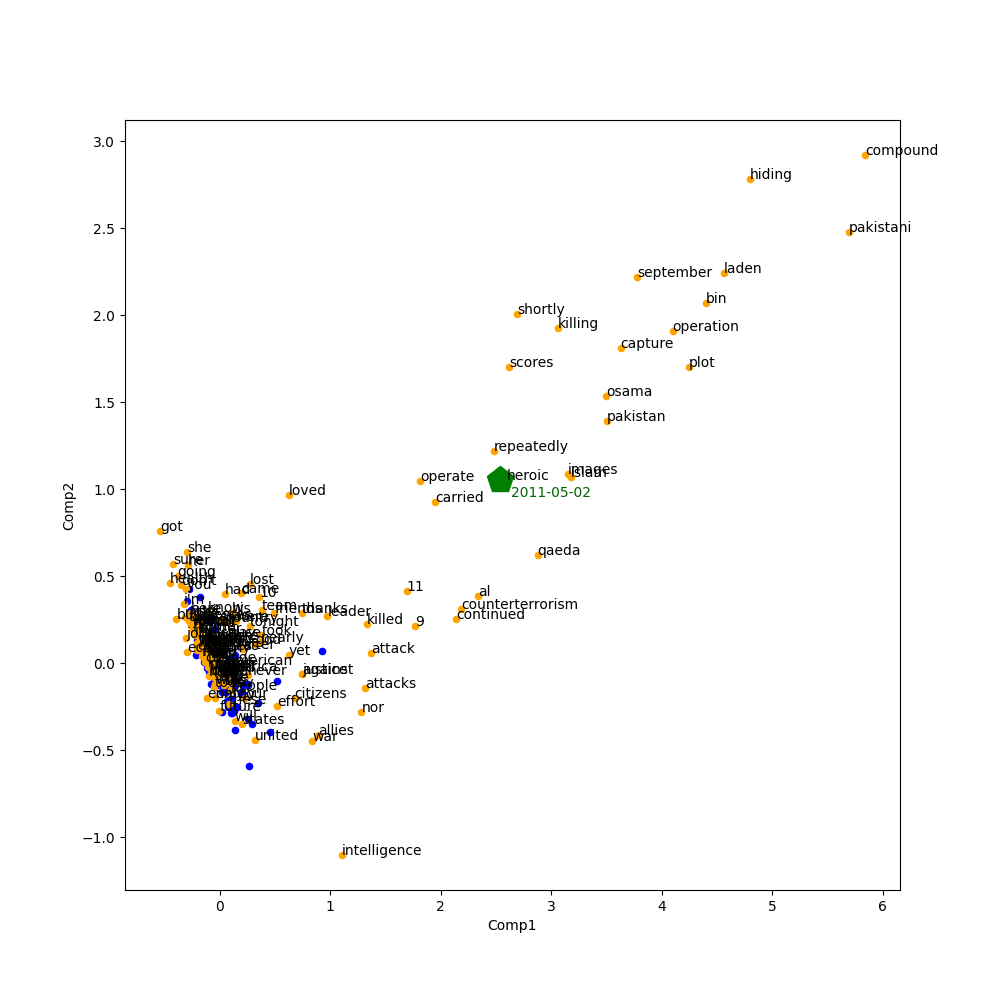

In [131]:
# 2011-07-26 debt ceiling
# 2011-05-02 Osama bin Laden killed
# 2011-09-09 Speech Jobs Act
# 2011-06-23 Afghanistan Pullout
# 2011-05-23 Missouri Tornado

# Sort words from one speech by difference between observed and expected
date = '2011-05-02'
# label location adjustment
x=0.1
y=-0.1
#make word list from difference between observed and expected
over_rep = difference[difference.index.str.startswith(date)].iloc[0].sort_values(ascending=False)[0:75]
under_rep = difference[difference.index.str.startswith(date)].iloc[0].sort_values(ascending=False)[-75:]
over_rep = pd.DataFrame(over_rep)
under_rep = pd.DataFrame(under_rep)

word_list = pd.concat([over_rep, under_rep])
word_list.columns = ['difference']
word_list['word']=word_list.index
word_list.drop(word_list.loc[word_list['word']=='â'].index, inplace=True) # get rid of that pesky goofy a
# Make a short contingency list using topic words
ctabshort = ctab.loc[ : , [col for col in ctab.columns if col in list(word_list['word'])]]
ctabshort.dropna(inplace=True)
# Keep it to the most common 150 words
if np.shape(ctabshort)[1] > 150:
    ctabshort=ctabshort.iloc[:, : 150]
    
ctabshort.columns.rename('words', inplace=True)
ctabshort.index.rename('speeches', inplace=True)
# Fit Correspondence Analysis with speeches and specified word list
ca = ca.fit(ctabshort)

date1 = '2011-05-02'     # date1 - red X   --- uncomment ax.plot line 46 to highlight two points
date2 = date             # date2 - green pentagon 
df1=ca.row_coordinates(ctabshort)
df1.columns=['Comp1', 'Comp2']
df2=ca.column_coordinates(ctabshort)
df2.columns=['Comp1', 'Comp2']

# df1 for speeches
ax = df1.plot(x='Comp1', y='Comp2', figsize=(10, 10), kind='scatter', color='blue')
#Label speech points
#for i, txt in enumerate(df1.index.values.tolist()):
#    ax.annotate(txt, (df1['Comp1'][i], df1['Comp2'][i]))

# df2 for words
df2.plot(ax=ax, x='Comp1', y='Comp2', kind='scatter', color='orange')
for i, txt in enumerate(df2.index.values.tolist()):
    ax.annotate(txt, (df2['Comp1'][i], df2['Comp2'][i]))

#ax.plot(df1.loc[[date1]]['Comp1'], df1.loc[[date1]]['Comp2'], marker='X', color='red', markersize=20)
#ax.annotate(date1, (df1['Comp1'][date1]+0.1, df1['Comp2'][date1]), color='darkred')
ax.plot(df1.loc[[date2]]['Comp1'], df1.loc[[date2]]['Comp2'], marker='p', color='green', markersize=20)
ax.annotate(date2, (df1['Comp1'][date2]+x, df1['Comp2'][date2]+y), color='darkgreen')

#plt.xlim([-0.25, 5.0])
#plt.ylim([-1.2, 1.0])
plt.show()